# **Requirement 1**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm

### **Utility fuctions**

In [20]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

def compute_weights(rho, rewards, costs):
  l = len(rewards)
  c = (-rewards).tolist() # declare coefficients of the objective function
  A_in = [costs.tolist()] # declare the inequality constraint matrix
  b_in = [rho] # declare the inequality constraint vector
  A_e = [np.ones(l)] # declare the equality constraint matrix
  b_e = [1] # declare the equality constraint vector
  results = linprog(c=c, A_ub=A_in, b_ub=b_in, A_eq=A_e, b_eq=b_e, method='highs-ds')   # solve
  return results.x

### **Pricing problem**

In [21]:
# Environment definition
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

In [22]:
# Parameters definition
max_price = 20
min_price = 10
cost = min_price # I set the cost to min price because that is the worst case for the seller (0 profit on a sale)
T = 365
daily_customers = 100
K = 100 # discretization intervals

conversion_probability = lambda p: 1-p/max_price #linear demand curve
reward_function = lambda price, cost, n_sales: (price - cost) * n_sales

prices = np.linspace(min_price,max_price, K) # 100 different prices between 10 and 20

# let's compute the clairvoyant: it is the repetition for T times of the maximum daily profit
daily_profit_curve = reward_function(prices, cost, daily_customers * conversion_probability(prices))
best_price_index = np.argmax(daily_profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(daily_profit_curve[best_price_index], T)

In [23]:
# Gaussian Process definition
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [24]:
# GPUCB Agent definition
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [25]:
# Interaction between agent and environment
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
agent = GPUCBAgent(T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=daily_customers)
    agent.update(r_t/daily_customers)
    agent_rewards = np.append(agent_rewards, r_t)

pricing_cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

prices = rescale(agent.action_hist, min_price, max_price)
profits = agent.reward_hist

gp = RBFGaussianProcess(scale=2)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(10,20,100))

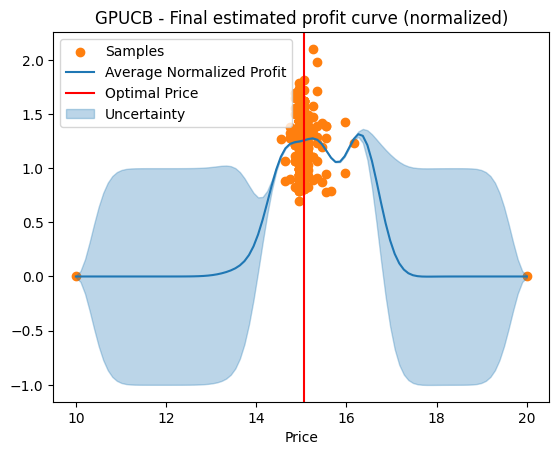

In [26]:
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(10,20,100), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(10,20,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

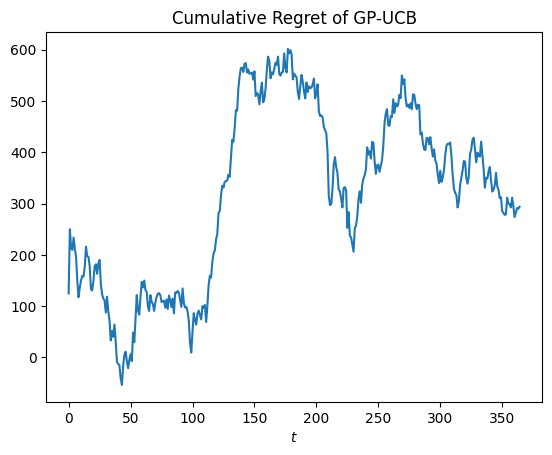

In [27]:
plt.figure()
plt.plot(pricing_cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

### **Auction Problem**

In [28]:
# Abstract class of an auction
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [29]:
# Second price auctions definition
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

In [30]:
# Utility function to generate gaussian samples (i need this to generate the other bidders distributions)
def generate_gaussian(mean, std_dev, num_samples, lower_bound=0, upper_bound=1):
    samples = []
    while len(samples) < num_samples:
        sample = np.random.normal(mean, std_dev)
        if lower_bound <= sample <= upper_bound:
            samples.append(sample)
    return samples

# Returns the best possible reward consdering at each round the best competing bid (m_t)
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0 #cumulative expenses
    i = 0
    while c <= B-1 and i < n_users: #until budget depletion and until end of auctions
        clairvoyant_bids[sorted_round_utility[i]] = 1 #i win the auctions starting from the most profitable one (to win i just bid 1 because i pay the next highest offer not mine)
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [31]:
# environmental settings
T = 365
B = 150
n_advertisers = 4 # the learner is included in the advertisers
ctrs = np.ones(n_advertisers) # simplifying assumption: all ctrs are 1
my_valuation = 0.8

# Gaussian Competitors
other_bidders_mean = [0.5, 0.7, 0.8]
other_bidders_std_dev = [0.4, 0.3, 0.1]
other_bids = np.array([generate_gaussian(other_bidders_mean[i], other_bidders_std_dev[i], T) for i in range(n_advertisers - 1)])

# best competing bid at each round
m_t = other_bids.max(axis=0)

clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, T)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_7796\4011838902.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')


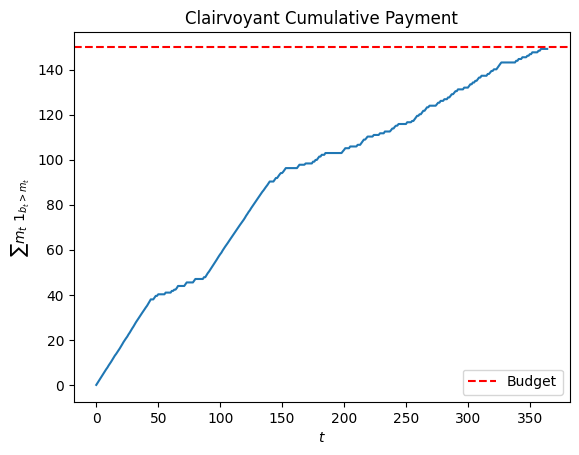

In [32]:
plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

In [33]:
# Truthful Second Price Auction Agent definition
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1) # Scaled bid

    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        #Update the lambda
        self.budget -= c_t

In [34]:
class UCB1Agent:
    def __init__(self, bids_set,valuation, budget, T, range=1):

        self.bids_set = bids_set
        self.K = len(bids_set)
        self.T = T
        self.range = range

        self.a_t = None
        self.average_rewards = np.zeros(self.K)
        self.average_costs = np.zeros(self.K)
        self.N_pulls = np.zeros(self.K)
        self.t = 0

        self.budget = budget
        self.valuation = valuation
        self.rho = self.budget/self.T

    def bid(self):
      if self.budget < 1:
            return 0
      else:
        if self.t < self.K:
            self.a_t = (self.t) / (self.K-1) #rescaled bid
        else:
            ucbs_rewards = self.average_rewards + self.range*np.sqrt(2*np.log(self.t)/self.N_pulls) #can also use self.T instead of self.t
            ucbs_costs = self.average_costs - self.range*np.sqrt(2*np.log(self.t)/self.N_pulls) #can also use self.T instead of self.t

            weights = compute_weights(self.rho, ucbs_rewards, ucbs_costs)
            self.a_t = np.random.choice(np.arange(self.K), p=weights) / (self.K-1)

            #self.a_t = np.argmax(ucbs_rewards) / self.K
        return self.a_t

    def update(self, r_t, c_t):
        index = int(self.a_t*(self.K-1))

        self.N_pulls[index] += 1
        self.average_rewards[index] += (r_t - self.average_rewards[index])/self.N_pulls[index]
        self.average_costs[index] += (c_t - self.average_costs[index])/self.N_pulls[index]

        self.t += 1
        self.budget -= c_t

In [35]:
# Auction simulation
eta = 1/np.sqrt(T) # from theory
# auction_agent = MultiplicativePacingAgent(valuation=my_valuation, budget=B, T=T, eta=eta)
auction_agent = UCB1Agent(bids_set=np.linspace(0, 1, 10), valuation=my_valuation, budget=B, T=T) # 10 different possible bids between 0 and 1
auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

for u in range(T):
    # interaction
    my_bid = auction_agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    auction_agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 69


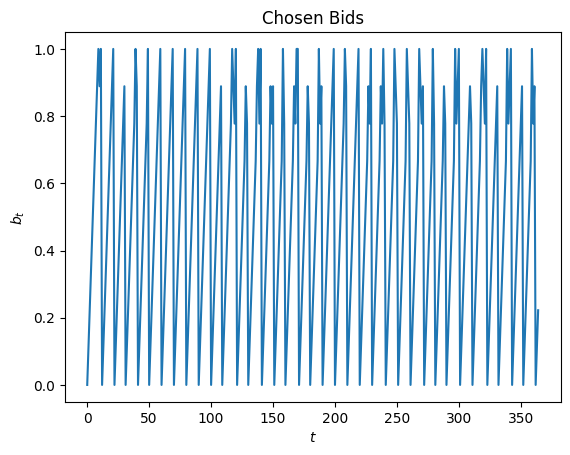

In [36]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_7796\4024054808.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


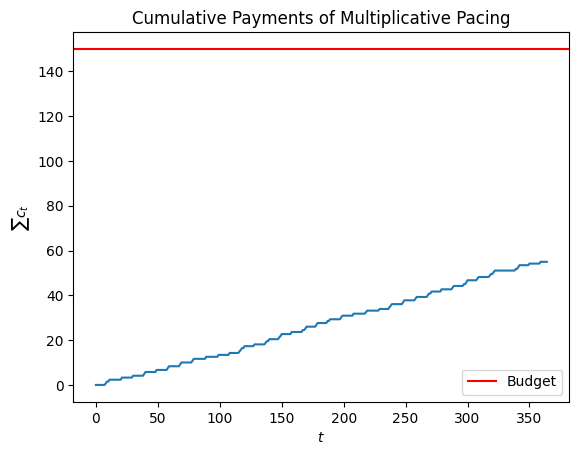

In [37]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Bidding agent')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_7796\2527399726.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum f_t$')


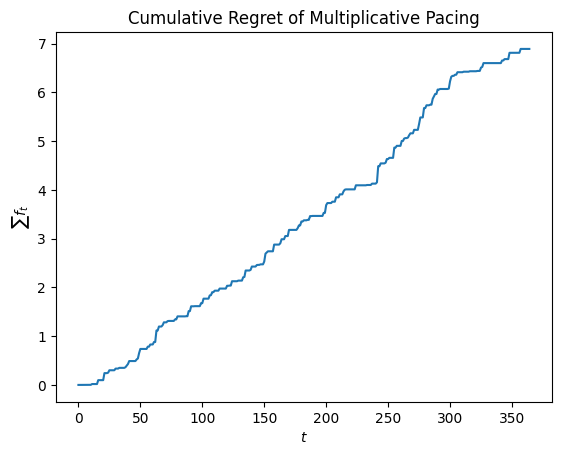

In [38]:
auction_cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(auction_cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Bidding agent')
plt.show()

### **Joint behaviour**

In [39]:
# Interaction between pricing and auction algorithms

n_runs = 4
cumulative_regret_per_trial = []

for _ in tqdm(range(n_runs)):

    T = 1000
    daily_customers = 100
    eta = 1/np.sqrt(daily_customers * T) # from theory
    B = 150 * 3.5 * daily_customers # 150 units per day
    prices = np.linspace(min_price,max_price, 100) # 100 different prices between 10 and 20

    n_advertisers = 4 # the learner is included in the advertisers
    ctrs = np.ones(n_advertisers) # simplifying assumption: all ctrs are 1
    my_valuation = 0.8

    auction_agent = MultiplicativePacingAgent(valuation=my_valuation, budget=B,T=T * daily_customers, eta=eta)
    auction = SecondPriceAuction(ctrs)

    pricing_agent = GPUCBAgent(T, discretization=100)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    
    utilities = [[] for _ in range(T)]
    my_bids = [[] for _ in range(T)]
    my_payments = [[] for _ in range(T)]
    total_wins = np.zeros(T)

    expected_clairvoyant_rewards = np.array([])
    pricing_agent_rewards = np.array([])

    # generate other bids for every auction
    other_bids = np.array([generate_gaussian(other_bidders_mean[i], other_bidders_std_dev[i], T * daily_customers) for i in range(n_advertisers - 1)])
    m_t = other_bids.max(axis=0) # take the max competing bid for each auction

    for t in tqdm(range(T)): # each day
        
        p_t = pricing_agent.pull_arm() # choose a price
        p_t = rescale(p_t, min_price, max_price) # rescale the price

        for u in range(daily_customers): # each auction

            my_bid = auction_agent.bid() # bid for the auction
            bids = np.append(my_bid, other_bids[:, u].ravel())
            winners, payments_per_click = auction.round(bids=bids)
            my_win = int(winners==0)
            f_t, c_t = (my_valuation-m_t[u + t*daily_customers])*my_win, m_t[u + t*daily_customers]*my_win
            auction_agent.update(f_t, c_t)

            # logging
            utilities[t] = np.append(utilities[t], f_t)
            my_bids[t] = np.append(my_bids[t], my_bid)
            my_payments[t] = np.append(my_payments[t], c_t)
            total_wins[t] += my_win
                
        d_t, r_t = env.round(p_t, n_t=total_wins[t])
        if total_wins[t] != 0: # if total wins is 0, I don't update the pricing agent, so also self.t does not increase. It is possible to have a mismatch between the pricing agent t and T at the end of the simulation
            pricing_agent.update(r_t/total_wins[t])
        pricing_agent_rewards = np.append(pricing_agent_rewards, r_t)

        # compute the clairvoyant for each day
        daily_profit_curve = reward_function(prices, cost, total_wins[t] * conversion_probability(prices)) # the daily profit curve is calculated using the number of wins of the day
        best_price_index = np.argmax(daily_profit_curve)
        best_price = prices[best_price_index] # calculate the price that maximizes the profit each day
        expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, daily_profit_curve[best_price_index])

    pricing_cumulative_regret = np.cumsum(expected_clairvoyant_rewards-pricing_agent_rewards)
    cumulative_regret_per_trial.append(pricing_cumulative_regret)

100%|██████████| 4/4 [02:50<00:00, 42.66s/it]


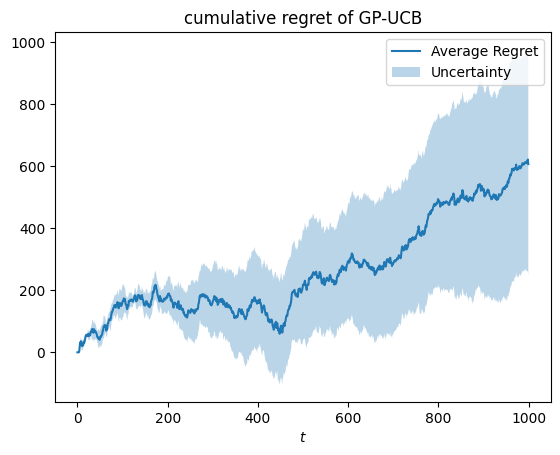

In [40]:
cumulative_regret_per_trial = np.array(cumulative_regret_per_trial)

average_regret = cumulative_regret_per_trial.mean(axis=0)
regret_sd = cumulative_regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of GP-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_runs),
                average_regret+regret_sd/np.sqrt(n_runs),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

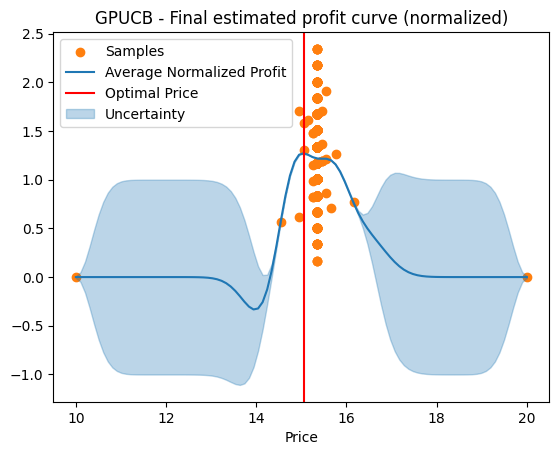

In [41]:
chosen_prices = rescale(pricing_agent.action_hist, min_price, max_price)
profits = pricing_agent.reward_hist
gp = RBFGaussianProcess(scale=2)
gp.fit(chosen_prices, profits)
mu, sigma = gp.predict(np.linspace(10,20,100))

plt.scatter(chosen_prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(10,20,100), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(10,20,100), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

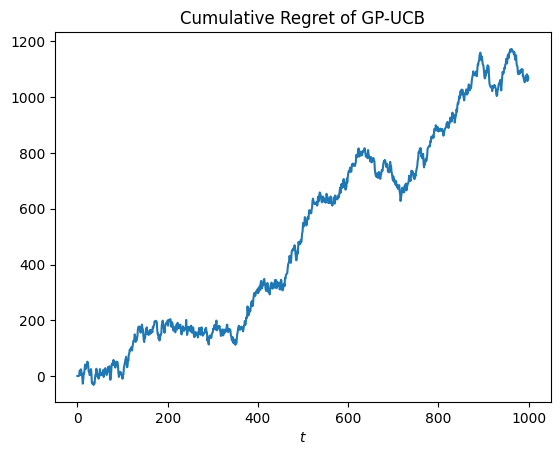

In [42]:
plt.figure()
plt.plot(pricing_cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

In [43]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, daily_customers * T)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_7796\4011838902.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')


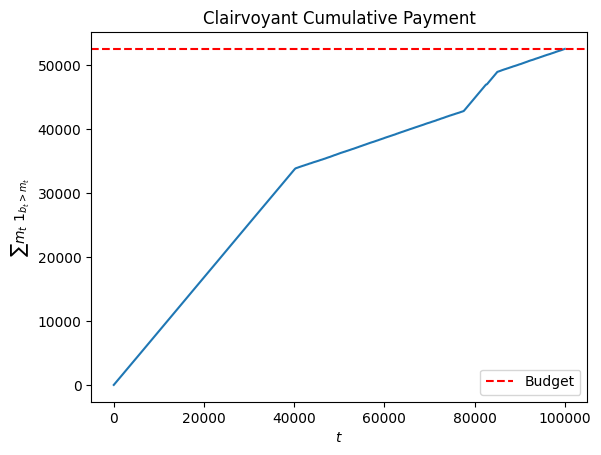

In [44]:
plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_7796\4186050847.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


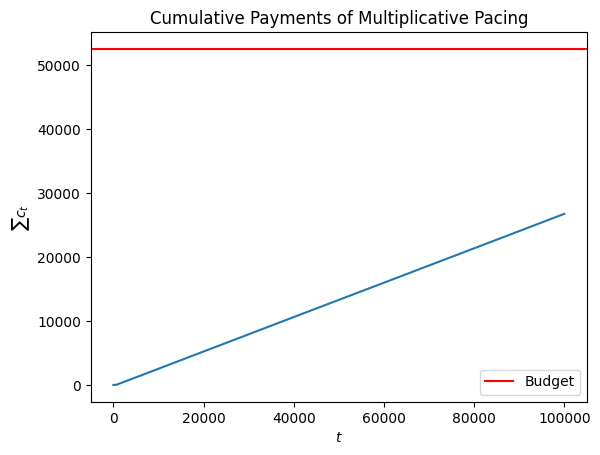

In [45]:
flatten_payments = np.array(my_payments).flatten()
cumulative_payments = np.cumsum(flatten_payments)

plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Bidding agent')
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rbegl\AppData\Local\Temp\ipykernel_7796\2658400807.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum f_t$')


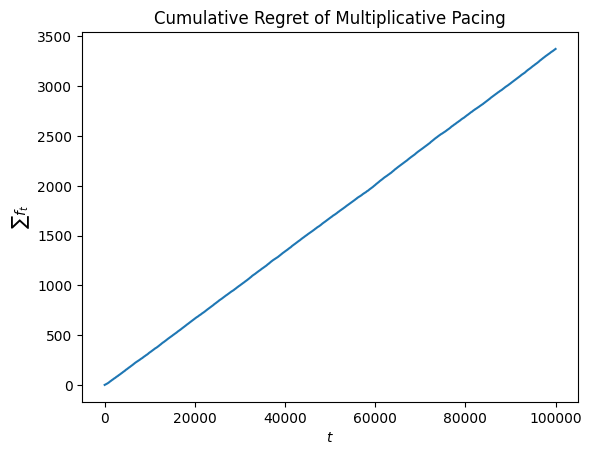

In [46]:
flatten_utilities = np.array(utilities).flatten()

auction_cumulative_regret = np.cumsum(clairvoyant_utilities-flatten_utilities)
plt.plot(auction_cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Bidding agent')
plt.show()